In [159]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import math
pd.options.mode.chained_assignment = None

## Dataset loading

In [160]:
tr = pd.read_csv("DA_titanic_train.csv")
te = pd.read_csv("DA_titanic_test.csv")

In [161]:
tr['train_or_test']='train'
te['train_or_test']='test'
df = pd.concat([tr,te])

In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 266
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    891 non-null    int64  
 1   Survived       624 non-null    float64
 2   Pclass         891 non-null    int64  
 3   Name           891 non-null    object 
 4   Sex            891 non-null    object 
 5   Age            714 non-null    float64
 6   SibSp          891 non-null    int64  
 7   Parch          891 non-null    int64  
 8   Ticket         891 non-null    object 
 9   Fare           891 non-null    float64
 10  Cabin          204 non-null    object 
 11  Embarked       889 non-null    object 
 12  train_or_test  891 non-null    object 
dtypes: float64(3), int64(4), object(6)
memory usage: 97.5+ KB


In [163]:
for column in tr.columns:
    print("A {} oszlopnak {} egyedi eleme van".format(column,len(tr[column].unique())))

A PassengerId oszlopnak 624 egyedi eleme van
A Survived oszlopnak 2 egyedi eleme van
A Pclass oszlopnak 3 egyedi eleme van
A Name oszlopnak 624 egyedi eleme van
A Sex oszlopnak 2 egyedi eleme van
A Age oszlopnak 85 egyedi eleme van
A SibSp oszlopnak 7 egyedi eleme van
A Parch oszlopnak 7 egyedi eleme van
A Ticket oszlopnak 516 egyedi eleme van
A Fare oszlopnak 210 egyedi eleme van
A Cabin oszlopnak 105 egyedi eleme van
A Embarked oszlopnak 4 egyedi eleme van
A train_or_test oszlopnak 1 egyedi eleme van


Az 'Age' és 'Cabin' oszlopok hiányosak. A Cabin bemeneti jellemzőt el fogom dobni, mivel az egy egyedi attribútum, nem lehet pótolni közel helyesen a  hiányzó adatokat. Az 'Age' oszlop esetében a hiányzó értékeket a medián korral hellyettesítem, ezzel a legjobb megoldást választom, hogy pótoljam a hiányzó adatokat.

Az Embarked oszlopban van 2 érték ami hiányzik, ezeket megvizsgálom, hogy mivel lehet érdemes helyettesíteni.

In [164]:
def plot_chart(feature):
    survived = tr[tr['Survived']==1][feature].value_counts()
    dead = tr[tr['Survived']==0][feature].value_counts()
    df = pd.DataFrame([survived,dead])
    df.index = ['Survived','Dead']
    df.plot(kind='bar',stacked=True, figsize=(8,5), title = feature)

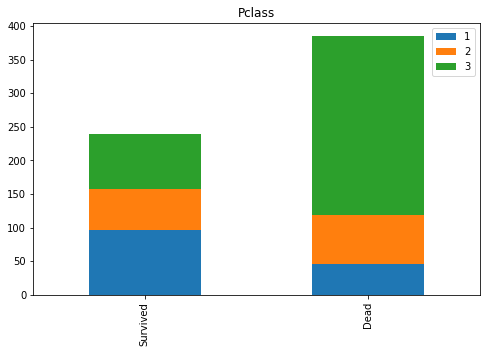

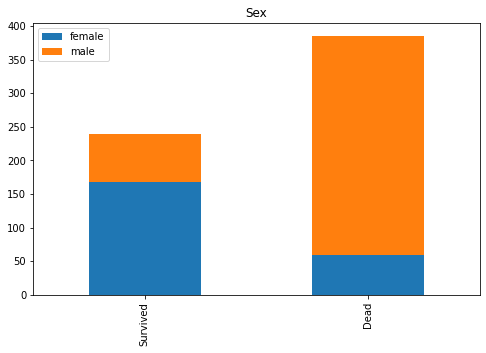

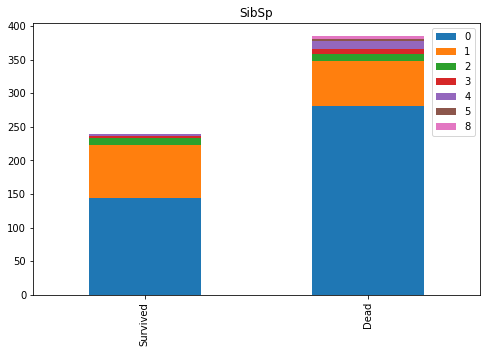

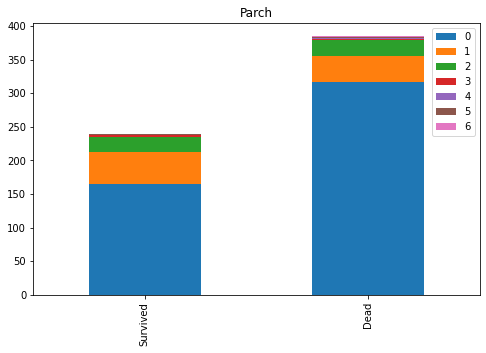

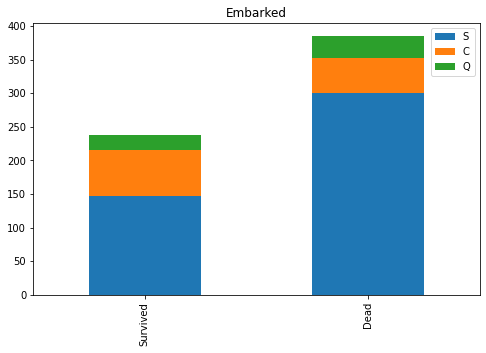

In [166]:
plot_columns = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
for column in plot_columns:
    plot_chart(column)

In [168]:
for att in df.columns:
    if att == "Survived":
        pass
    elif att == "Embarked":
        df[att]=df[att].fillna('S')
    elif df[att].dtype == object:
        df[att]=df[att].fillna('no_data')
    else:
        df[att]=df[att].fillna(np.nanmedian(df[att]))

In [169]:
label_encoder = LabelEncoder()
column_object_list = ['Sex','Embarked']
for column in column_object_list:
    df[column] = label_encoder.fit_transform(df[column])

In [170]:
features = []
for att in df.columns:
    if df[att].dtype!= object:
        features.append(att)
        
colsNotToInclude = ['PassengerId', 'Survived']
features = [col for col in features if col not in colsNotToInclude]

In [171]:
train_df = df[df['train_or_test']=='train'].copy()
test_df = df[df['train_or_test']=='test'].copy()

## Változó fontosság

Az alábbiakban egy GradientBoosting modellt futtatok le az adathalmazomra, és megvizsgálom az egyes változók hatását a célváltozóra az értékük szempontjából.

In [172]:
model = GradientBoostingClassifier(random_state=42)

Pclass


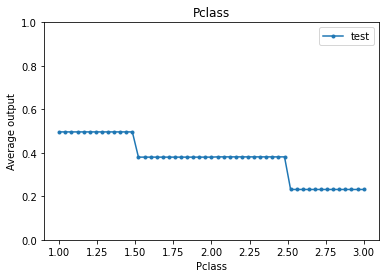

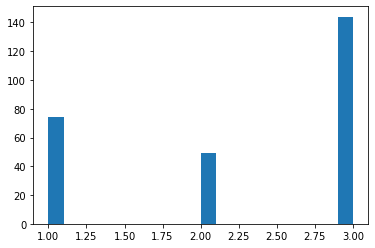

Sex


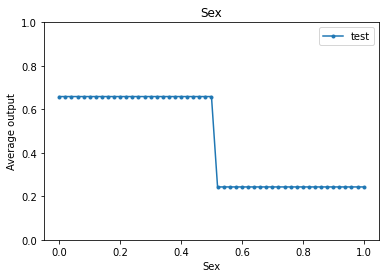

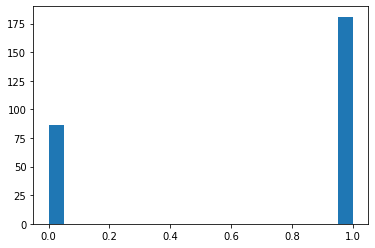

Age


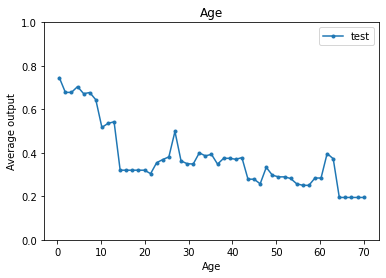

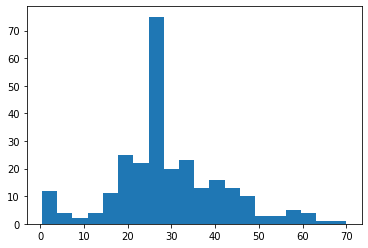

SibSp


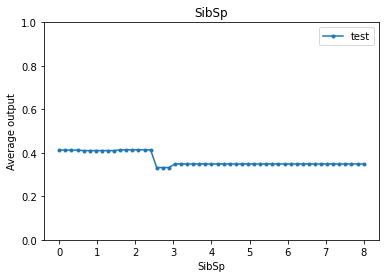

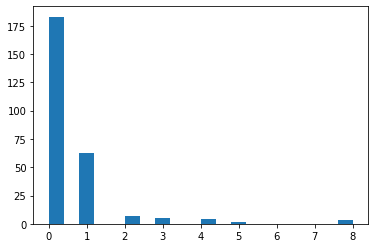

Parch


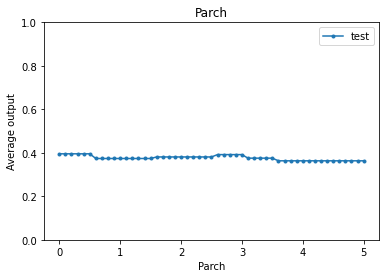

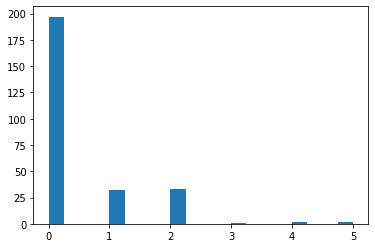

Fare


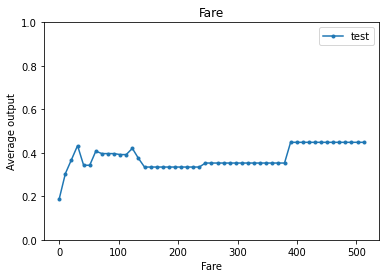

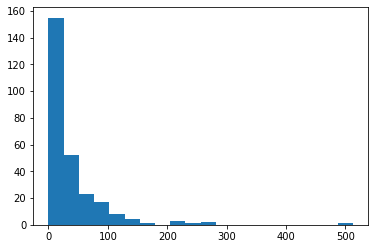

Embarked


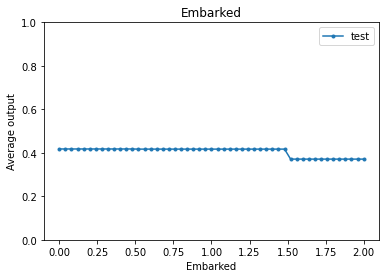

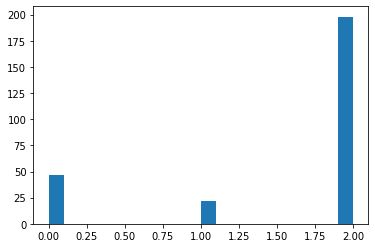

In [173]:
model.fit(train_df[features],train_df["Survived"])
for variable in features: 
    print(variable)
    xmin=test_df[variable].min()
    xmax=test_df[variable].max()
    step_size=(xmax-xmin)/50
    cdf = test_df.copy()
    xdf = train_df.copy()
    x_t=[]
    y_t=[]
    y2_t=[]
    for value in np.arange(xmin, xmax+step_size, step_size):
        #print(ertek,end=' ')
        cdf[variable]=value
        xdf[variable]=value
        pred = model.predict_proba(cdf[features])[:,1]
        avg_pred=np.mean(pred)
        x_t.append(value)
        y_t.append(avg_pred)
    if np.min(y_t)!=np.max(y_t):
        plt.title(variable)
        plt.xlabel(variable)
        plt.ylabel("Average output")
        plt.ylim(0,1)
        plt.plot(x_t,y_t,marker='.',label='test')
        plt.legend()
        plt.show()
        
        plt.hist(test_df[variable],bins=20)
        plt.show()

## Bemeneti jellemzők értékelése

Látható, hogy a 'Sex' oszlop és 'Pclass' oszlopok nagyban meghatározzák a célváltozó kimenetelét. Ezeken felül, a 'Fare' és 'Age' változók azok amiknél szintén nagyobb változás figyelhető meg a végpontok között, azonban ezeket érdemes lenne csoportosítani, a sok eltérő érték miatt.

Az 'Age' oszlopot 6 egyenlő intervallumú csoportra, míg a 'Fare'-t 4 csoportra osztom, úgy, hogy a benne lévő személyek száma egyenlő legyen a 4 csoportban.

In [174]:
df['Age_bin'] = pd.cut(df['Age'],6)
df['Fare_bin'] = pd.qcut(df['Fare'],4)
dummies = ['Age_bin','Fare_bin']
df = pd.get_dummies(df,columns = dummies)

In [175]:
train_df = df[df['train_or_test']=='train'].copy()
test_df = df[df['train_or_test']=='test'].copy()

In [176]:
features = []
for att in df.columns:
    if df[att].dtype!= object:
        features.append(att)
        
colsNotToInclude = ['PassengerId', 'Survived','Age','Fare']
features = [col for col in features if col not in colsNotToInclude]

In [177]:
df[features].head()

,Pclass,Sex,SibSp,Parch,Embarked,"Age_bin_(0.34, 13.683]","Age_bin_(13.683, 26.947]","Age_bin_(26.947, 40.21]","Age_bin_(40.21, 53.473]","Age_bin_(53.473, 66.737]","Age_bin_(66.737, 80.0]","Fare_bin_(-0.001, 7.91]","Fare_bin_(7.91, 14.454]","Fare_bin_(14.454, 31.0]","Fare_bin_(31.0, 512.329]"
0,3,1,1,0,2,0,1,0,0,0,0,1,0,0,0
1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1
2,3,0,0,0,2,0,1,0,0,0,0,0,1,0,0
3,3,1,0,0,2,0,0,1,0,0,0,0,1,0,0
4,2,0,1,0,0,0,1,0,0,0,0,0,0,1,0


## Paraméter optimalizálás

In [192]:
parameter_space = {
    'n_estimators': [11,13,15,17],
    'max_depth': [2,3,4,5],
    'learning_rate': [0.1,0.5,1]
}
parameter_space_random_forest = {
    'n_estimators': [20,25,30,35,40],
    'max_depth': [2,3,5,7],
    'min_samples_leaf': [1,2,3]
}

parameter_space_knn = {
    'n_neighbors' : [9,10,11,12,13]
}
models = {
    'random forest': RandomForestClassifier(random_state=42),
    'gradient boost' : GradientBoostingClassifier(random_state=42),
    'knn' : KNeighborsClassifier()
}

In [193]:
from sklearn.model_selection import GridSearchCV
for model in models.values():
    if (list(models.keys())[list(models.values()).index(model)]) == 'random forest':
        clf = GridSearchCV(model, parameter_space_random_forest, n_jobs=-1)
    if (list(models.keys())[list(models.values()).index(model)]) == 'knn':
        clf = GridSearchCV(model, parameter_space_knn, n_jobs=-1)
    if (list(models.keys())[list(models.values()).index(model)]) == 'gradient boost':
        clf = GridSearchCV(model, parameter_space, n_jobs=-1)
    clf.fit(train_df[features],train_df['Survived'])
    print('Best parameters found for {}:\n'.format(list(models.keys())[list(models.values()).index(model)]),clf.best_params_)

Best parameters found for random forest:
 {'max_depth': 7, 'min_samples_leaf': 2, 'n_estimators': 40}
Best parameters found for gradient boost:
 {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 13}
Best parameters found for knn:
 {'n_neighbors': 11}


## Modellek lefuttatása

In [201]:
iteration = KFold(n_splits=5)
train_acc_list = []
test_acc_list = []
X, y = train_df[features], train_df['Survived']
models = {
    'gradient boost' : GradientBoostingClassifier(learning_rate=0.1 ,n_estimators = 13, max_depth=4,  random_state=42),
    'random forest': RandomForestClassifier(max_depth = 7,min_samples_leaf=2,n_estimators=40,random_state=42),
    'kNN classifier': KNeighborsClassifier(n_neighbors=11),
    'SVM' : SVC()
}
for model in models.values():
    for train_idx, test_idx in iteration.split(X, y):
        train_train_df = train_df.iloc[train_idx]
        train_test_df = train_df.iloc[test_idx]
        #train_train_df[features] = scaler.fit_transform(train_train_df[features])
        #train_test_df[features] = scaler.fit_transform(train_test_df[features])
        model.fit(train_train_df[features], train_train_df['Survived'])
        train_train_df['prediction'] = model.predict(train_train_df[features])
        train_test_df['prediction'] = model.predict(train_test_df[features])
    
        trainAcc = roc_auc_score(train_train_df['Survived'], train_train_df['prediction'])
        testAcc = roc_auc_score(train_test_df['Survived'], train_test_df['prediction'])
    
        train_acc_list.append(trainAcc)
        test_acc_list.append(testAcc)
    print("{} classifier: Train dataset AUC:{:.5}% , Test dataset AUC:{:.5}%".format(list(models.keys())[list(models.values()).index(model)],sum(train_acc_list)/len(train_acc_list)*100,sum(test_acc_list)/len(test_acc_list)*100))

gradient boost classifier: Train dataset AUC:83.554% , Test dataset AUC:80.281%
random forest classifier: Train dataset AUC:85.359% , Test dataset AUC:81.1%
kNN classifier classifier: Train dataset AUC:84.562% , Test dataset AUC:80.49%
SVM classifier: Train dataset AUC:83.724% , Test dataset AUC:80.53%


In [ ]:
A lgejobb AUC score-t a RandomForest modell használatával értem el, így azt fogom lefuttatni a teszt adathalmazra.

In [206]:
model = RandomForestClassifier(max_depth = 7,min_samples_leaf=2,n_estimators=40,random_state=42)
model.fit(train_df[features], train_df['Survived'])

RandomForestClassifier(max_depth=7, min_samples_leaf=2, n_estimators=40,
                       random_state=42)

In [207]:
te['prediction']=model.predict(test_df[features])

In [209]:
te.drop(columns='train_or_test')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,prediction
0,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1.0
1,6,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,0.0
2,7,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,0.0
3,8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,0.0
4,9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
262,880,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56.0,0,1,11767,83.1583,C50,C,1.0
263,882,3,"Markun, Mr. Johann",male,33.0,0,0,349257,7.8958,NaN,S,0.0
264,886,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q,0.0
265,887,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0.0


In [210]:
te.to_csv("DA_titanic_test_predicted.csv", index=False)